# Pet Image Classifier

## Pre Processing

### Download data

In [1]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!tar -xf *.tar.gz

--2020-12-11 21:59:19--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  35.3MB/s    in 22s     

2020-12-11 21:59:41 (34.4 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf annotations.tar.gz

--2020-12-11 21:59:48--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  17.8MB/s    in 1.0s    

2020-12-11 21:59:50 (17.8 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [3]:
# remove .mat files
!rm images/*.mat

In [4]:
classes="""yorkshire terrier dog
russian blue cat
japanese chin dog
persian cat
saint bernard dog
abyssinian cat
bombay cat
wheaten terrier dog
chihuahua dog
english cocker spaniel dog
samoyed dog
staffordshire bull terrier dog
bengal cat
beagle dog
sphynx cat
great pyrenees dog
american pit bull terrier dog
egyptian mau cat
pomeranian dog
english setter dog
pug dog
ragdoll cat
leonberger dog
maine coon cat
havanese dog
miniature pinscher dog
german shorthaired dog
american bulldog dog
scottish terrier dog
british shorthair cat
siamese cat
boxer dog
keeshond dog
basset hound dog
shiba inu dog
birman cat
newfoundland dog""".split('\n')

In [5]:
# prepare folders
import os
try:
  os.mkdir("train")
except:
  pass
for i in classes:
  try:
    os.mkdir("train/"+i)
  except:
    pass

In [6]:
def get_folder_file(filename):
  c = ""
  if filename[0].isupper():
    c = " cat"
  else:
    c = " dog"
  return filename.lower()[:filename.lower().rfind('_')].replace('_',' ') + c


In [8]:
from shutil import copyfile
images = os.listdir('images')
for image in images:
  # os.makedirs(get_folder_file(image),exist_ok=True)
  copyfile('images/'+image, 'train/'+ get_folder_file(image) + '/' + image)
data_dir = 'train'

## Classify

### Import TensorFlow and other libraries

In [9]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [10]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [11]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [15]:
data_root = 'train' # data folder

In [16]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7390 files belonging to 37 classes.
Using 5912 files for training.


In [17]:
class_names = np.array(train_ds.class_names)
print(class_names)

['abyssinian cat' 'american bulldog dog' 'american pit bull terrier dog'
 'basset hound dog' 'beagle dog' 'bengal cat' 'birman cat' 'bombay cat'
 'boxer dog' 'british shorthair cat' 'chihuahua dog' 'egyptian mau cat'
 'english cocker spaniel dog' 'english setter dog'
 'german shorthaired dog' 'great pyrenees dog' 'havanese dog'
 'japanese chin dog' 'keeshond dog' 'leonberger dog' 'maine coon cat'
 'miniature pinscher dog' 'newfoundland dog' 'persian cat'
 'pomeranian dog' 'pug dog' 'ragdoll cat' 'russian blue cat'
 'saint bernard dog' 'samoyed dog' 'scottish terrier dog' 'shiba inu dog'
 'siamese cat' 'sphynx cat' 'staffordshire bull terrier dog'
 'wheaten terrier dog' 'yorkshire terrier dog']


In [18]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [21]:
result_batch = classifier.predict(train_ds)

In [22]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"

In [23]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [24]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [25]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 37)                47397     
Total params: 2,305,381
Trainable params: 47,397
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
predictions = model(image_batch)

In [27]:
predictions.shape

TensorShape([32, 37])

In [28]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [29]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=2,
                    callbacks=[batch_stats_callback])

Epoch 1/2
185/185 [==============================] - 7s 37ms/step - loss: 0.2015 - acc: 0.9583
Epoch 2/2
185/185 [==============================] - 7s 36ms/step - loss: 0.1226 - acc: 0.9583


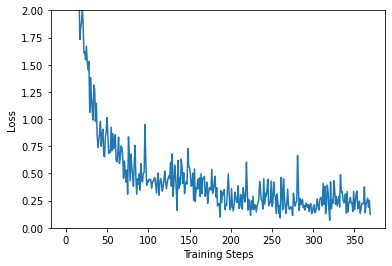

In [30]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

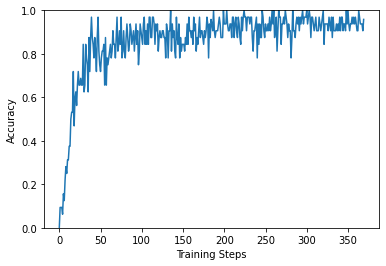

In [31]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [32]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

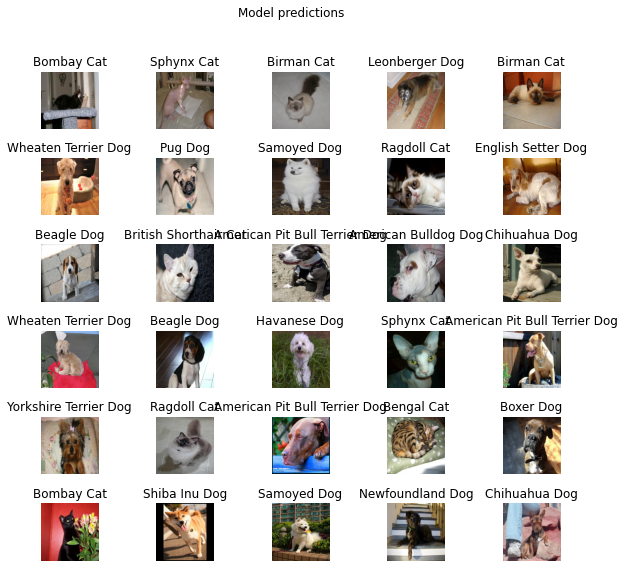

In [33]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [34]:
t = time.time()

export_path = "{}".format(int(t))
model.save(export_path)

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: 1607724263/assets


INFO:tensorflow:Assets written to: 1607724263/assets


'1607724263'

In [35]:
reloaded = tf.keras.models.load_model(export_path)

In [36]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [37]:
abs(reloaded_result_batch - result_batch).max()

0.0

### ***Now you can use the model generated in any tensorflow supported platforms and will act as a black box neural network that would give probabilities to each of the outputs mentioned.***

---

